# Mục mới

1DOWNLOAD DATASET

In [1]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 43.98 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31

In [3]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [4]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [5]:
train_df.head(5)

sentence  label
0  Mình đã đây dùng_bữa với món bún_chả rất ngon ...      1
1  Phù_hợp cho họp nhóm , giá_cả sinh_viên , thức...      1
2  Quán quá tuyệt luôn , chủ quán nhiệt_tình nữa ...      1
3  Tại đây < a class = ' hashtag-link ' href = ' ...      1
4  Tới đây hầu_như món nào mình cũng ưng_ý hết .\...      1

# Mục mới

PREPROCESSING

1/language detection


In [6]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941173 sha256=89bf3e640e8b9b993e7e242fbfd367dbe582a17c4a0b133cdefa46eb93fb99a8
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [8]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
  identifier = LanguageIdentifier.from_modelstring(model,norm_probs=True)
  not_vi_idx = set()
  THRESHOLD = 0.9
  for idx,row in df.iterrows():
    score = identifier.classify(row["sentence"])
    if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
      not_vi_idx.add(idx)
  vi_df = df[~df.index.isin(not_vi_idx)]
  not_vi_df = df[df.index.isin(not_vi_idx)]
  return vi_df,not_vi_df

In [9]:
train_df_vi, train_df_other = identify_vn(train_df)

In [10]:
train_df_vi

sentence  label
0      Mình đã đây dùng_bữa với món bún_chả rất ngon ...      1
1      Phù_hợp cho họp nhóm , giá_cả sinh_viên , thức...      1
2      Quán quá tuyệt luôn , chủ quán nhiệt_tình nữa ...      1
3      Tại đây < a class = ' hashtag-link ' href = ' ...      1
4      Tới đây hầu_như món nào mình cũng ưng_ý hết .\...      1
...                                                  ...    ...
29995  Trang_trí các phần ăn ko đẹp_mắt , mùi ko thơm...      0
29996  Chủ_nhật mình ghé quán vì đang thèm bánh_hỏi l...      0
29997  Cơm củng ngon nước châm vừa sường to nhưng hơi...      0
29998  Phục_vụ thì lơ nhơ , bánh_mì cũng ổn cơ_mà chỉ...      0
29999  Mi ̀ nh mua voucher , no ́ i chung ko nghi ̃ l...      0

[29736 rows x 2 columns]

2/preprocessing

In [11]:
import re
import string

def preprocess_text(text):
  url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
  text = url_pattern.sub(r" ",text)
  html_pattern = re.compile(r'<[^<>]+>')
  text = html_pattern.sub(" ", text)

  replace_chars = list(string.punctuation + string.digits)
  for char in replace_chars:
    text = text.replace(char, " ")
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r" ", text)
  text = " ".join(text.split())
  return text.lower()

In [12]:
train_df_vi['sentence'][0]

'Mình đã đây dùng_bữa với món bún_chả rất ngon , thịt mềm , ướp thơm , rau thì sạch_sẽ , thịt nhìu ăn ko hết , cáh bày trí thì đẹp_mắt , được cô chủ tiếp rất nhiệt_tình , giọng nói thì vô_cùng dễ_thương , không_gian quán hơi nhỏ , nhưng bày trí rất đẹp , có trên lầu nữa nhưng mình chưa lên , nói_chung khá tốt\n'

In [13]:
preprocess_text(train_df_vi['sentence'][0])

'mình đã đây dùng bữa với món bún chả rất ngon thịt mềm ướp thơm rau thì sạch sẽ thịt nhìu ăn ko hết cáh bày trí thì đẹp mắt được cô chủ tiếp rất nhiệt tình giọng nói thì vô cùng dễ thương không gian quán hơi nhỏ nhưng bày trí rất đẹp có trên lầu nữa nhưng mình chưa lên nói chung khá tốt'

In [14]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

<ipython-input-14-e21d2b59a2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [15]:
train_df

sentence  label
0      Mình đã đây dùng_bữa với món bún_chả rất ngon ...      1
1      Phù_hợp cho họp nhóm , giá_cả sinh_viên , thức...      1
2      Quán quá tuyệt luôn , chủ quán nhiệt_tình nữa ...      1
3      Tại đây < a class = ' hashtag-link ' href = ' ...      1
4      Tới đây hầu_như món nào mình cũng ưng_ý hết .\...      1
...                                                  ...    ...
29995  Trang_trí các phần ăn ko đẹp_mắt , mùi ko thơm...      0
29996  Chủ_nhật mình ghé quán vì đang thèm bánh_hỏi l...      0
29997  Cơm củng ngon nước châm vừa sường to nhưng hơi...      0
29998  Phục_vụ thì lơ nhơ , bánh_mì cũng ổn cơ_mà chỉ...      0
29999  Mi ̀ nh mua voucher , no ́ i chung ko nghi ̃ l...      0

[30000 rows x 2 columns]

In [16]:
valid_df

sentence  label  \
0     Lần đầu_tiên ăn_ở đây mà rất ư là hài_lòng về ...      1   
1     Mình tới quán lần đầu và đường cũng dễ tìm , q...      1   
2     Trước khi up reveiw mình cũng đã đọc 1 số bình...      1   
3     Thích chỗ này vì có khoáng ngọt : ) ) giá cũng...      1   
4     Anh chủ quán cực_kì thân_thiện , chăm mấy em m...      1   
...                                                 ...    ...   
9995  Quán này nằm phía trong cv phần_mềm QuAng Trun...      0   
9996  Pho ̀ ng phim đe ̣ p , phu ̣ c vu ̣ thân thiê ...      0   
9997  Hôm nọ mình với đứa bạn rủ nhau đi ăn thấy đc ...      0   
9998  Bữa giờ hay đi ăn các store Lotteria khác như ...      0   
9999  Thỉnh_thoảng cũng hay ngồi ở đây . Đồ uống ko ...      0   

                                    preprocess_sentence  
0     lần đầu tiên ăn ở đây mà rất ư là hài lòng về ...  
1     mình tới quán lần đầu và đường cũng dễ tìm quá...  
2     trước khi up reveiw mình cũng đã đọc số bình l...  
3     thích chỗ này vì có khoáng ngọt giá cũng ổn nữ...  
4     anh chủ quán cực kì thân thiện chăm mấy em mèo...  
...                                                 ...  
9995  quán này nằm phía trong cv phần mềm quang trun...  
9996  pho ̀ ng phim đe ̣ p phu ̣ c vu ̣ thân thiê ̣ ...  
9997  hôm nọ mình với đứa bạn rủ nhau đi ăn thấy đc ...  
9998  bữa giờ hay đi ăn các store lotteria khác như ...  
9999  thỉnh thoảng cũng hay ngồi ở đây đồ uống ko có...  

[10000 rows x 3 columns]

EDA


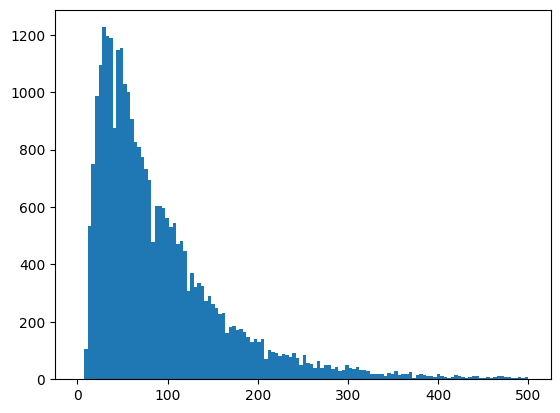

In [17]:
import matplotlib.pyplot as plt

plt.hist([len(sentence.split()) for sentence in train_df_vi['preprocess_sentence']], bins=128, range=(0, 500))
plt.show()

# Mục mới

TEXT REPRESENTATION

In [18]:
!pip install -q torchtext==0.16.0

In [19]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [20]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [21]:
tokenizer(train_df_vi['preprocess_sentence'][0])[:5]

['mình', 'đã', 'đây', 'dùng', 'bữa']

In [22]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [23]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

# Mục mới

data loader

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    encoded_sentences, labels, offsets = [], [], [0]
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)
        offsets.append(encoded_sentence.size(0))

    labels = torch.tensor(labels, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    encoded_sentences = torch.cat(encoded_sentences)
    return encoded_sentences.to(device), offsets.to(device), labels.to(device)

In [25]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [26]:
next(iter(train_dataloader))

(tensor([394, 350, 107,  ..., 166, 132,  20]),
 tensor([    0,   287,   364,   432,   452,   719,   829,   923,   962,  1251,
          1303,  1359,  1537,  1563,  1683,  1699,  1766,  1832,  1851,  1900,
          1920,  1982,  2029,  2072,  2141,  2154,  2186,  2345,  2369,  2385,
          2496,  2644,  2744,  2828,  2849,  2934,  3014,  3038,  3224,  3281,
          3304,  3455,  3493,  3595,  3671,  3920,  3978,  4008,  4065,  4103,
          4280,  4323,  4403,  4514,  4724,  4785,  4926,  4976,  5013,  5029,
          5065,  5083,  5167,  5368,  5493,  5637,  5684,  5885,  5945,  6257,
          6292,  6568,  6622,  6695,  6794,  6845,  6875,  7182,  7364,  7394,
          7441,  7465,  7548,  7631,  7690,  7720,  7804,  7870,  7968,  7990,
          8151,  8229,  8270,  8400,  8529,  8582,  8627,  8652,  8664,  8700,
          8812,  8909,  8941,  8976,  9056,  9216,  9542,  9599,  9668,  9743,
          9915, 10057, 10162, 10249, 10438, 10454, 10491, 10534, 10563, 10627,
     

In [27]:
encoded_sentences, offsets, labels = next(iter(train_dataloader))

In [28]:
encoded_sentences.shape

torch.Size([12198])

MODEL

In [29]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, seq_len):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.ft = nn.Flatten()
        self.fc = nn.Linear(seq_len*embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        ouput = self.ft(embedded)
        return self.fc(ouput)

In [30]:
batch_size = 5
seq_len = 10
input = torch.ones([batch_size, seq_len], dtype=torch.int32)
input

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)

In [31]:
num_class = 2
vocab_size = 5000
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class, seq_len)

In [32]:
model

TextClassificationModel(
  (embedding): Embedding(5000, 100)
  (ft): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1000, out_features=2, bias=True)
)

In [33]:
predictions = model(input)
predictions

tensor([[-0.3320, -1.1536],
        [-0.3320, -1.1536],
        [-0.3320, -1.1536],
        [-0.3320, -1.1536],
        [-0.3320, -1.1536]], grad_fn=<AddmmBackward0>)

Embading bag

In [34]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, inputs, offsets):
        embedded = self.embedding(inputs, offsets)
        return self.fc(embedded)

In [35]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

In [36]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(10000, 100, mode='mean')
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [37]:
predictions = model(encoded_sentences, offsets)

In [38]:
predictions

tensor([[ 5.0404e-02, -2.7092e-01],
        [ 5.3194e-02,  6.3424e-02],
        [-1.0343e-02, -5.6347e-02],
        [ 2.7358e-01,  3.0502e-02],
        [-7.2113e-02,  8.0499e-02],
        [-1.1224e-01, -3.9657e-02],
        [ 2.2929e-01,  8.1286e-02],
        [-3.3366e-02,  1.5367e-02],
        [ 3.3927e-03,  6.3678e-02],
        [ 5.1844e-02,  3.1216e-02],
        [-4.8487e-03, -5.1738e-02],
        [ 1.8423e-03, -8.5492e-02],
        [ 1.2248e-01,  2.6598e-01],
        [ 1.9776e-02, -5.5144e-01],
        [-8.3006e-02, -7.7295e-02],
        [ 6.0132e-02,  1.4856e-01],
        [ 1.2669e-01, -2.1368e-02],
        [ 1.3934e-02,  8.1355e-02],
        [ 1.8799e-01,  1.8751e-01],
        [ 7.5649e-02, -8.0539e-02],
        [ 1.4575e-02, -3.8420e-02],
        [-3.2802e-02, -1.5339e-02],
        [-1.8009e-01,  1.0786e-01],
        [ 5.2942e-02, -3.4309e-02],
        [-5.9437e-02,  6.2766e-02],
        [ 1.7574e-02,  5.6357e-02],
        [-4.0153e-03,  1.3247e-01],
        [ 2.0677e-03, -7.064

In [39]:
learning_rate = 2e-5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [40]:
loss = criterion(predictions, labels)

In [41]:
loss

tensor(0.7074, grad_fn=<NllLossBackward0>)

# Mục mới

TRAIN


In [42]:
import time

def train(model, optimizer, criterion, train_dataloader, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, offsets, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predictions = model(inputs, offsets)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [43]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader)

| epoch   0 |    50/  233 batches | accuracy    0.489
| epoch   0 |   100/  233 batches | accuracy    0.479
| epoch   0 |   150/  233 batches | accuracy    0.497
| epoch   0 |   200/  233 batches | accuracy    0.494


In [44]:
epoch_acc, epoch_loss

(0.4752994011976048, 0.7005706769714029)

In [45]:
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, offsets, labels) in enumerate(valid_dataloader):
            predictions = model(inputs, offsets)
            loss = criterion(predictions, labels)
            losses.append(loss)
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [46]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)

In [47]:
eval_acc, eval_loss

(0.4952, tensor(0.6996))

In [48]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

learning_rate = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 10
for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, epoch)
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

| epoch   1 |    50/  233 batches | accuracy    0.646
| epoch   1 |   100/  233 batches | accuracy    0.800
| epoch   1 |   150/  233 batches | accuracy    0.821
| epoch   1 |   200/  233 batches | accuracy    0.841
-----------------------------------------------------------
| End of epoch   1 | Time:  1.79s | Train Accuracy    0.852 | Train Loss    0.466 | Valid Accuracy    0.852 | Valid Loss    0.385 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.853
| epoch   2 |   100/  233 batches | accuracy    0.860
| epoch   2 |   150/  233 batches | accuracy    0.860
| epoch   2 |   200/  233 batches | accuracy    0.861
-----------------------------------------------------------
| End of epoch   2 | Time:  1.37s | Train Accuracy    0.862 | Train Loss    0.360 | Valid Accuracy    0.866 | Valid Loss    0.364 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.870
| epoch   3 

In [49]:
model = model.to('cpu')

In [50]:
def predict(text):
    with torch.no_grad():
        encoded = torch.tensor(vocabulary(tokenizer(text)))
        output = model(encoded, torch.tensor([0]))
        return output.argmax(1).item()

In [51]:
test_df.iloc[0]

sentence               Nhà_hàng này có view chắc đẹp nhất Aeon_Mall_B...
label                                                                  1
preprocess_sentence    nhà hàng này có view chắc đẹp nhất aeon mall b...
Name: 0, dtype: object

In [52]:
# compute accuracy on test set

predictions, labels = [], []
for index, row in test_df.iterrows():
    sentence = row['preprocess_sentence']
    label = row['label']
    prediction = predict(sentence)
    predictions.append(prediction)
    labels.append(label)

sum(torch.tensor(predictions) == torch.tensor(labels))/len(labels)

tensor(0.8622)